# Import Statements

In [1]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import math
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from sklearn.preprocessing import LabelEncoder
import PIL
import matplotlib.pyplot as plt
import glob

# Reading the Metadata

In [2]:
root = "D:\IIIT-D\Summer Semester\CAPSTONE PROJECT\Complete Dataset"

In [3]:
metadata = pd.read_csv(root+"\HAM10000_metadata")

In [4]:
metadata['dx'].value_counts()

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

In [5]:
le = LabelEncoder()

In [6]:
le.fit(metadata['dx'])

LabelEncoder()

In [7]:
metadata['class_label']=le.transform(metadata['dx'])

In [8]:
metadata['class_label'].value_counts()

5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: class_label, dtype: int64

# Organising The Dataset

In [9]:
# classes=metadata['dx'].unique().tolist()

In [10]:
# import shutil

In [11]:
# source_dir="D:\IIIT-D\Summer Semester\CAPSTONE PROJECT\Complete Dataset\HAM10000_all_images"
# dest_dir="D:/IIIT-D/Summer Semester/CAPSTONE PROJECT/Complete Dataset/Class Wise Organised Images/"

In [12]:
# class_images=[]
# for i in tqdm(classes,):
#   if not os.path.exists(dest_dir + str(i) + "/"): 
#     os.mkdir(dest_dir + str(i) + "/")
#   image_ids = metadata[metadata['dx'] == i]['image_id']
#   class_images.extend(image_ids)
#   for id in tqdm(class_images):
#     if os.path.exists(dest_dir + i + "/"+id+".jpg"):
#       continue
#     else:
#       shutil.copyfile((source_dir + "/"+ id +".jpg"), (dest_dir + i + "/"+id+".jpg"))
#   class_images=[] 

# Train Test Split 

In [13]:
# !pip install split-folders tqdm

In [14]:
# import splitfolders
# input_folder = root+'/Class Wise Organised Images'
# output_folder = root+'/Train_Val_Test_Split'
# splitfolders.ratio(input=input_folder, output=output_folder, seed=1337, ratio=(.8, .1, .1), group_prefix=None)

# Build A Model

## Preprocessing

In [15]:
train_datagen = ImageDataGenerator(rescale= 1./255,
                                   featurewise_center=False,  # set input mean to 0 over the dataset
                                   samplewise_center=False,  # set each sample mean to 0
                                   featurewise_std_normalization=False,  # divide inputs by std of the dataset
                                   samplewise_std_normalization=False,  # divide each input by its std
                                   zca_whitening=False,  # apply ZCA whitening
                                   rotation_range=90,  # randomly rotate images in the range (degrees, 0 to 180)
                                   zoom_range = 0.1, # Randomly zoom image 
                                   width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
                                   height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
                                   horizontal_flip=True,  # randomly flip images
                                   vertical_flip=True,  # randomly flip images
                                   shear_range = 10)

In [16]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [17]:
train_data = train_datagen.flow_from_directory(root+"/Hair Removed Images/train",target_size=(64,64),batch_size=32,class_mode='categorical')

Found 8010 images belonging to 7 classes.


In [18]:
val_data = test_datagen.flow_from_directory(root+"/Hair Removed Images/val",target_size=(64,64),batch_size=32,class_mode='categorical')

Found 1000 images belonging to 7 classes.


In [19]:
test_data = test_datagen.flow_from_directory(root+"/Hair Removed Images/test",target_size=(64,64),batch_size=32,class_mode='categorical')

Found 1007 images belonging to 7 classes.


### **ResNet50 Model with class weights**

In [20]:
label = [ 'akiec', 'bcc','bkl','df','mel', 'nv',  'vasc']

def estimate_weights_mfb(label):
    class_weights = np.zeros_like(label, dtype=np.float)
    counts = np.zeros_like(label)
    for i,l in enumerate(label):
        counts[i] = metadata[metadata['dx']==str(l)]['dx'].value_counts()[0]
    counts = counts.astype(np.float)
    #print(counts)
    median_freq = np.median(counts)
    #print(median_freq)
    #print(weights.shape)
    for i, label in enumerate(label):
        #print(label)
        class_weights[i] = median_freq / counts[i]
    return class_weights

classweight= estimate_weights_mfb(label)

for i in range(len(label)):
    print(label[i],":", classweight[i])

akiec : 1.5718654434250765
bcc : 1.0
bkl : 0.467697907188353
df : 4.469565217391304
mel : 0.4618149146451033
nv : 0.07665920954511558
vasc : 3.619718309859155


In [21]:
from tensorflow.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout
from tensorflow.keras import regularizers
import numpy as np

model = Sequential()
num_labels = 7

base_model = ResNet50(include_top=False, input_shape=(32, 32, 3),pooling = 'avg', weights = 'imagenet')
model = Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(num_labels, activation = 'softmax',))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 903       
Total params: 23,850,887
Trainable params: 23,797,767
Non-trainable params: 53,120
_________________________________________________________________


In [22]:
from tensorflow.keras.callbacks import ReduceLROnPlateau ,EarlyStopping
from tensorflow.keras.optimizers import Adam
optimizer = Adam (learning_rate=1e-5)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy",tf.keras.metrics.AUC(curve='ROC')])

In [24]:
EPOCHS = 150

BATCH_SIZE = 16

classweights = {
  0 : 1.5718654434250765,
  1: 1.0,
  2 : 0.467697907188353,
  3 : 4.469565217391304,
  4 : 0.4618149146451033,
  5 : 0.07665920954511558,
  6 : 3.619718309859155
}


# train the model on the new data for a few epochs
history = model.fit(x=train_data,validation_data=val_data,
                              epochs = EPOCHS,verbose = 1, class_weight = classweights)

Epoch 1/150
251/251 [==============================] - 87s 319ms/step - loss: 1.2609 - accuracy: 0.2481 - auc: 0.6216 - val_loss: 26.4346 - val_accuracy: 0.0110 - val_auc: 0.4231
Epoch 2/150
251/251 [==============================] - 28s 110ms/step - loss: 1.0639 - accuracy: 0.2635 - auc: 0.6435 - val_loss: 44.7920 - val_accuracy: 0.0230 - val_auc: 0.4322
Epoch 3/150
251/251 [==============================] - 28s 111ms/step - loss: 0.8998 - accuracy: 0.3042 - auc: 0.6820 - val_loss: 8.4440 - val_accuracy: 0.1690 - val_auc: 0.6484
Epoch 4/150
251/251 [==============================] - 28s 110ms/step - loss: 0.8142 - accuracy: 0.3308 - auc: 0.7121 - val_loss: 1.7022 - val_accuracy: 0.3760 - val_auc: 0.7241
Epoch 5/150
251/251 [==============================] - 28s 110ms/step - loss: 0.7238 - accuracy: 0.3594 - auc: 0.7340 - val_loss: 1.4342 - val_accuracy: 0.4330 - val_auc: 0.8051
Epoch 6/150
251/251 [==============================] - 28s 110ms/step - loss: 0.6952 - accuracy: 0.3846 - au

# Building The Model

In [29]:
loss,accuracy,auc = model.evaluate(test_data)

print("loss: {}".format(loss))
print("accuracy: {}".format(accuracy))
print("AUC Score: {}".format(auc))

32/32 [==============================] - 2s 54ms/step - loss: 0.9514 - accuracy: 0.7229 - auc: 0.9471
loss: 0.9514062404632568
accuracy: 0.7229394316673279
AUC Score: 0.9471375942230225


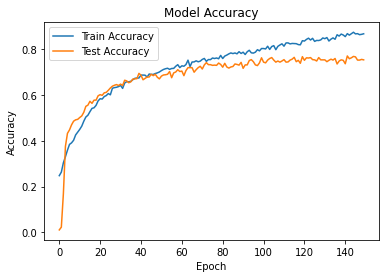

In [30]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train Accuracy', 'Test Accuracy'], loc='upper left')
plt.show()

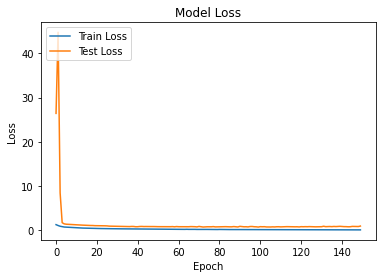

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train Loss', 'Test Loss'], loc='upper left')
plt.show()

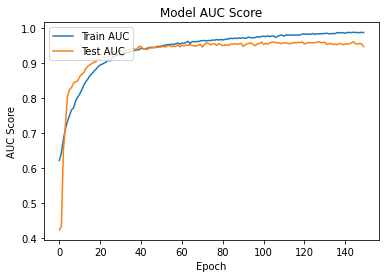

In [32]:
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('Model AUC Score')
plt.ylabel('AUC Score')
plt.xlabel('Epoch')
plt.legend(['Train AUC', 'Test AUC'], loc='upper left')
plt.show()

In [ ]:
# cnn.save('/content/drive/MyDrive/Capstone Project/Saved Models/first_model.h5')

In [ ]:
# from keras.models import load_model
# model = load_model("/content/drive/MyDrive/Capstone Project/Saved Models/first_model.h5")